In [82]:
import numpy as np
import matplotlib.pyplot as plt
from graspy.inference import SemiparametricTest
from graspy.embed import AdjacencySpectralEmbed
import seaborn as sns
import warnings
from graspy.simulations import binary_sbm, rdpg
from graspy.utils import symmetrize

warnings.filterwarnings("ignore")
FONTSIZE = 30

In [83]:
def perturb_latent_position(X, sigma):
    X2 = X + np.random.normal(loc=0, scale=sigma, size=X.shape)
    X2 = X2 / np.linalg.norm(X2, axis=0)
    return X2

def double_plot(A, X):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.scatterplot(X[:,0], X[:,1], ax=ax[1],alpha = 0.5,s=100)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[0].set_title('Adjacency matrix', fontsize=FONTSIZE)
    ax[1].set_title('Adjacency spectral embedding',fontsize=FONTSIZE)
    return ax

# Generate a stochastic block model graph to model as a random dot product graph
To start, we generate a binary stochastic block model graph (SBM). An SBM is composed of 'communities' or 'blocks,' where a node's block membership in a graph determines its probability of connection to the other nodes in the graph. 

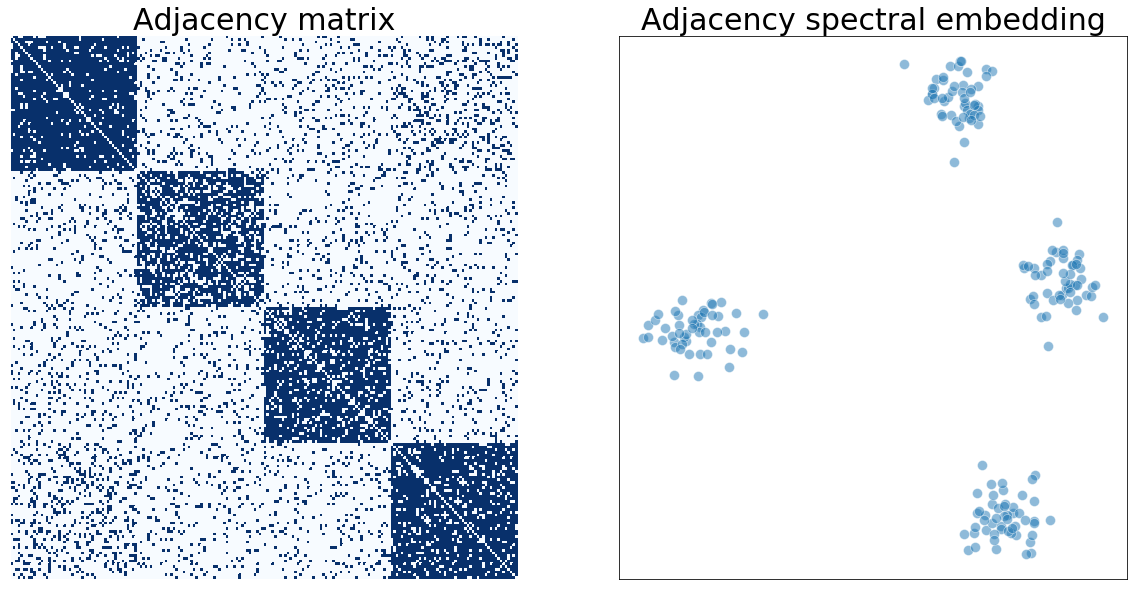

In [98]:
k = 4 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.11, 0.13, 0.2],
              [0, 0.7, 0.1, 0.1], 
              [0, 0, 0.8, 0.1],
              [0, 0, 0, 0.85]])

P = symmetrize(P)
csize=50
A1 = binary_sbm([csize, csize, csize, csize], P)
X1 = AdjacencySpectralEmbed(k=k).fit_transform(A1)
ax = double_plot(A1, X1)


In the adjacency matrix above, there is a clearly defined block structrure corresponding to the 4 communities in the graph that we established. On the right, we see the **adjacency spectral embedding (ASE)** of this graph. ASE(A) recovers an estimate of the **latent positions** of $A $. Latent positions refer to the idea of a **random dot product graph (RDPG)** which can be modeled as follows: 

For an adjacency matrix $A \in \mathbb{R}^{n x n}$, the probability of an edge existing between node $i$ and node $j$ (aka whether or not $A_{ij}$ is a 1) is determined by the matrix $P \in \mathbb{R}^{n x n}$

$P = X X^T$, where $X \in \mathbb{R}^{n x d} $ and is referred to as the latent positions of the graph. $X$ is referred to as the latent positions of the graph because each node $n_i$ is modeled as having a hidden, usually unobserved location in $\mathbb{R}^d$ (we'll call it $x_i$). The probability of an edge existing between $n_i$ and $n_j$ is equal to the dot product $x_i \cdot x_j$

ASE is one way to obtain an estimate of the latent positions of a graph, $\hat{X}$

In the above embedding, we see 4 clusters of nodes corresponding to the 4 blocks that we prescribed. ASE recovers the fact that all of the nodes in a block have similar latent positions. So, RDPGs can also model an SBM graph. 

# Sample new RDPGs from this latent position

Given the estimate of X, we now sample two new RDPGs from the same latent position above 

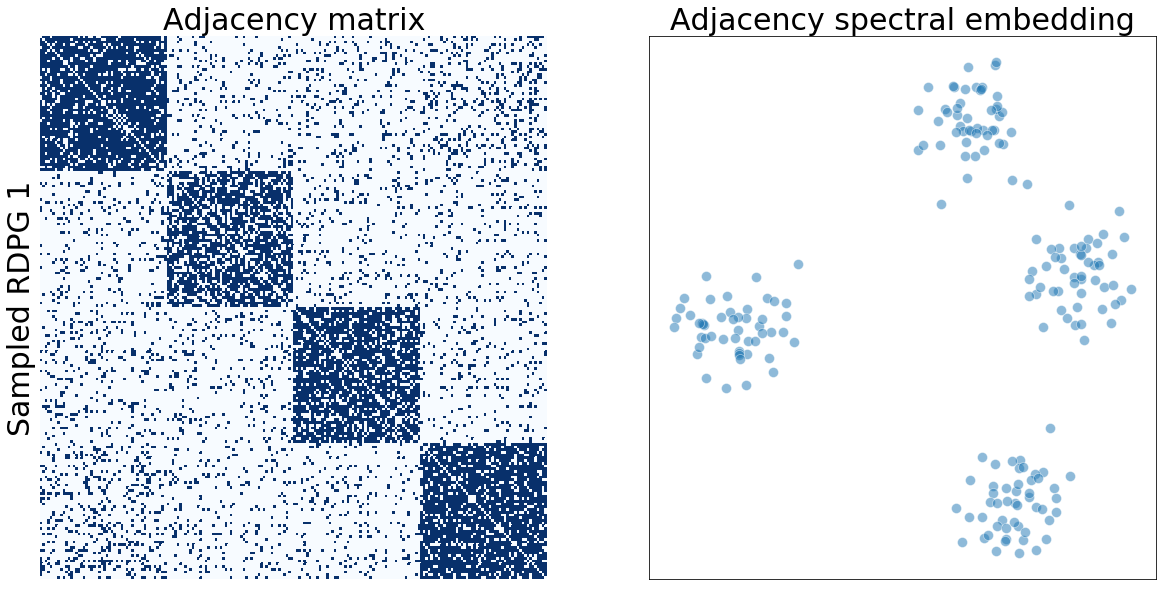

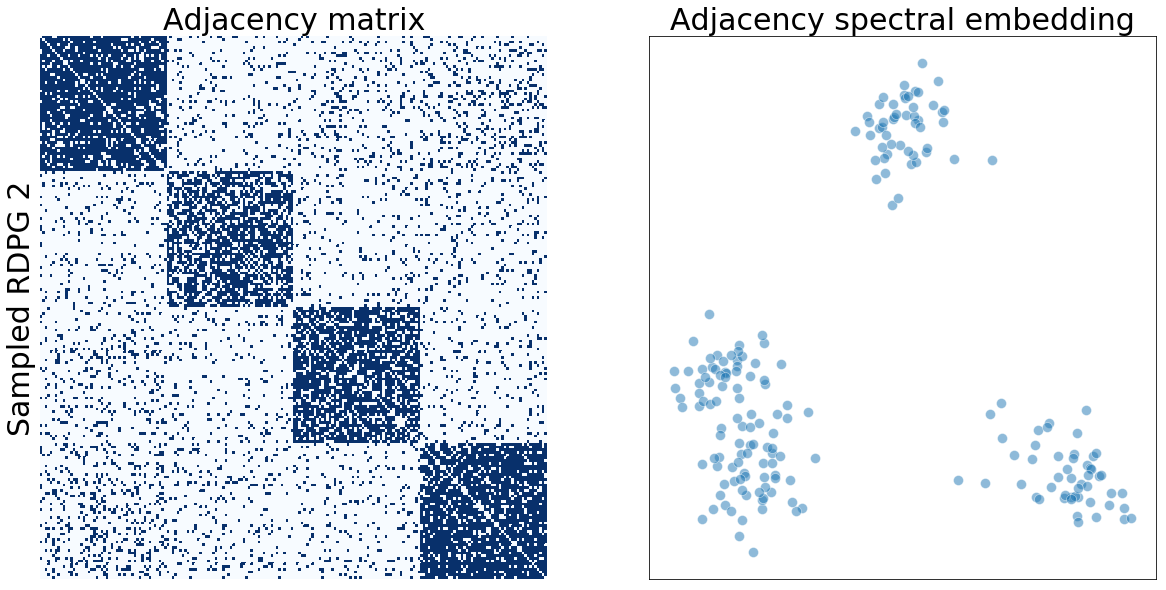

In [122]:
A2 = rdpg(X1)
A3 = rdpg(X1)
A2 = symmetrize(A2)
A3 = symmetrize(A3)
Xhat2 = AdjacencySpectralEmbed(k=k).fit(A2).X
Xhat3 = AdjacencySpectralEmbed(k=k).fit(A3).X

ax2 = double_plot(A2, Xhat2)
ax2[0].set_ylabel('Sampled RDPG 1', fontsize=FONTSIZE)
ax3 = double_plot(A3, Xhat3)
ax3[0].set_ylabel('Sampled RDPG 2', fontsize=FONTSIZE)
plt.show()

Qualitatively, both of the simulated RDPGs above match the behavior we would expect, with 4 clear blocks and the corresponding 4 clusters in the embedded space. But, can we say they were generated from the same latent positions?

# Semiparametric test
Now, we want to know whether the above two graphs were generated from the same latent position. We know that they were, so the test should predict that the differences between Sampled RDPG 1 and 2 (up to a rotation, see below) are no greater than those differences observed by chance

In other words, we are testing 
$$ H_0: X_1 = X_2 R$$
$$ H_a: X_1 \neq X_2 R$$

and want to see that the p-value for the semiparametric test is high (fail to reject the null)

Here, R is an orthogonal rotation matrix found from solving the [orthogonal procrustes problem](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.linalg.orthogonal_procrustes.html) (Note: this constraint can be relaxed for other versions of semipar)


In [119]:
spt = SemiparametricTest(n_bootstraps=1000, n_components=4)
spt.fit(A2, A3)
print('p = {}'.format(spt.p))

p = 0.9785


We see that the corresponding p-value is high, indicating that the observed differences between latent positions of Sampled RDPG 1 and 2 are likely due to chance

# Plot the t-distributions generated by the semiparametric test

How did the semiparametric test work? In order to asses the differences in latent positions of Sampled RDPG 1 and 2, we needed the distribution of differences between latent positions of RDPGs that **are** from the same latent positions. To do so, we take the latent position of the sample, generate two sampled RDPGs from that latent position, and compute the difference between the latent positions of those simulated graphs. We do this computation $n_{bootstraps}$ number of times, generating a distribution (plotted below).

## Pseudocode/math:

$ ASE(A_{1}) \rightarrow \hat{X_1}$

$P = \hat{X_1}\hat{X_1}^T$

For b = 1:$n_{bootstraps}$: 
> $A_{sim}^1 \sim P$

> $A_{sim}^2 \sim P$

> $T[b] = \|A_{sim}^1R - A_{sim}^2 \|_F$

We can do the same for the other input adjacency matrix $A_2$, to generate two distributions of T's. We use the one that yields the higher p-value for a more conservative test.

Below, we plot the distribution of differences generated from the latent position of Sampled RDPG 1 (left) and Sampled RDPG 2 (right). The orange lines show where the observed difference in latent positions between our samples falls in these distributions.

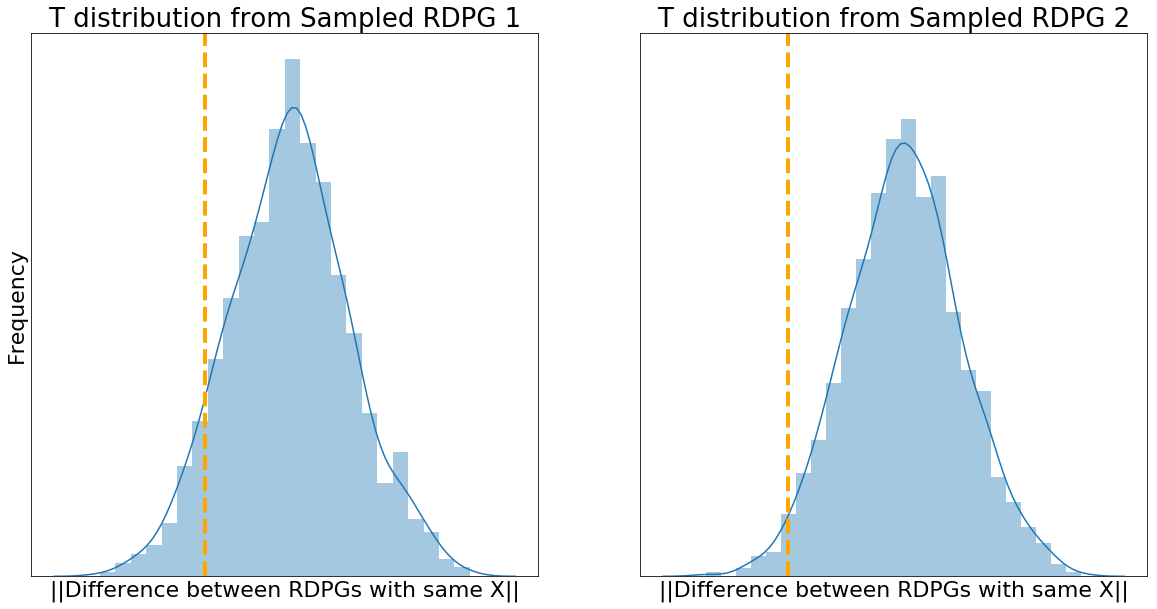

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.distplot(spt.T1_bootstrap, ax=ax[0], norm_hist=True)
sns.distplot(spt.T2_bootstrap, ax=ax[1], norm_hist=True)
linestyle = '--'
color = 'orange'
linewidth = 4
ax[0].axvline(spt.T_sample, linestyle=linestyle, color=color, linewidth=linewidth)
ax[1].axvline(spt.T_sample, linestyle=linestyle, color=color, linewidth=linewidth)
ax[0].set_title('T distribution from Sampled RDPG 1', fontsize=FONTSIZE-4)
ax[1].set_title('T distribution from Sampled RDPG 2', fontsize=FONTSIZE-4)
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_xlabel('||Difference between RDPGs with same X||', fontsize=FONTSIZE-8)
ax[1].set_xlabel('||Difference between RDPGs with same X||', fontsize=FONTSIZE-8)
ax[0].set_ylabel('Frequency', fontsize=FONTSIZE-8)
plt.show()

The p-value generated from each of these distributions can be thought of as the area under the curve that is above the orange line.

# What are the properties of X_hat?

In [121]:
k = 4 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.11, 0.13, 0.2],
              [0, 0.7, 0.1, 0.1], 
              [0, 0, 0.8, 0.1],
              [0, 0, 0, 0.85]])

P = symmetrize(P)
csize=50
A1 = binary_sbm([csize, csize, csize, csize], P)
X1 = AdjacencySpectralEmbed(k=k).fit_transform(A1)
print(X1.shape)
print(np.linalg.norm(X1, axis=0))
print(np.linalg.norm(X1, axis=1))
P = X1 @ X1.T
print(P.shape)
print(P.max())
print(np.diag(P))
P = P - np.diag(np.diag(P))
print(P.max())

(200, 4)
[5.67427362 5.79243869 6.10202889 7.78132815]
[0.9489735  0.99681571 1.00044441 0.91997275 0.93546206 0.93515993
 1.00599462 0.94103433 0.95882773 0.866913   0.90468343 0.98223542
 0.94552302 0.97882362 0.9571974  0.94216053 1.02186894 0.86203328
 0.97742287 0.9594768  0.96270846 0.92504519 0.9538192  0.9865519
 0.94972947 0.96338575 0.92498845 0.94445072 0.91183018 0.89454001
 0.95828871 0.98063723 0.88800574 0.96145771 0.91056566 0.95549615
 0.98708543 0.92105461 0.95445407 0.93559401 0.89471865 1.00184996
 1.04024638 0.9805136  0.91507363 0.90697915 0.89885743 0.93584799
 0.92008803 0.98013882 0.86516057 0.88838605 0.84218253 0.75619657
 0.93302778 0.66308469 0.69137463 0.8478802  0.92500582 0.91500337
 0.72779714 0.84736943 0.76731375 0.70584092 0.77458413 0.83140991
 0.67163367 0.84126954 0.78043426 0.88107819 0.92143    0.85074451
 0.83498788 1.01432252 0.85046755 0.91111115 0.88447659 0.88020476
 0.88883281 0.72865616 0.98944684 0.81716838 0.79228008 0.8233194
 0.841892